<a href="https://colab.research.google.com/github/adniislami/adni/blob/main/Pristina_VegChange_2017_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install rasterio geopandas matplotlib numpy

In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import os
import pandas as pd
import rasterio.features
import osmnx as ox

=== DATA VERIFICATION ===
2017 CRS: EPSG:32634
2017 Unique values: [0 1 2]
2024 CRS: EPSG:32634
2024 Unique values: [0 1 2]
AOI CRS: EPSG:32634
AOI bounds: [ 508740.77891019 4717383.54153357  517510.44657201 4727178.1624051 ]
AOI area (calculated): 39.432845639182986 km²

=== RASTER MASKING ===
2017 raster shape: (1334, 1191)
2024 raster shape: (1334, 1191)

=== AREA INFORMATION ===
Pixel width: 7.37 m
Pixel height: 7.35 m
Single pixel area: 54.17 m² (0.000054 km²)
Total pixels in AOI: 727,862
Total AOI area: 39.43 km²

=== YEAR 2017 (Threshold 0.23) ===
Total vegetation: 500,685 px (68.8%)
Vegetation area: 27.12 km²
  - Deciduous: 465,988 px (64.0%)
  - Evergreen: 34,697 px (4.8%)
Non-vegetation: 227,177 px (31.2%)

=== YEAR 2024 (Threshold 0.23) ===
Total vegetation: 478,040 px (65.7%)
Vegetation area: 25.90 km²
  - Deciduous: 407,984 px (56.1%)
  - Evergreen: 70,056 px (9.6%)
Non-vegetation: 249,822 px (34.3%)

=== CHANGE ANALYSIS 2017-2024 ===
Total analyzed pixels: 727,862
Vegetat

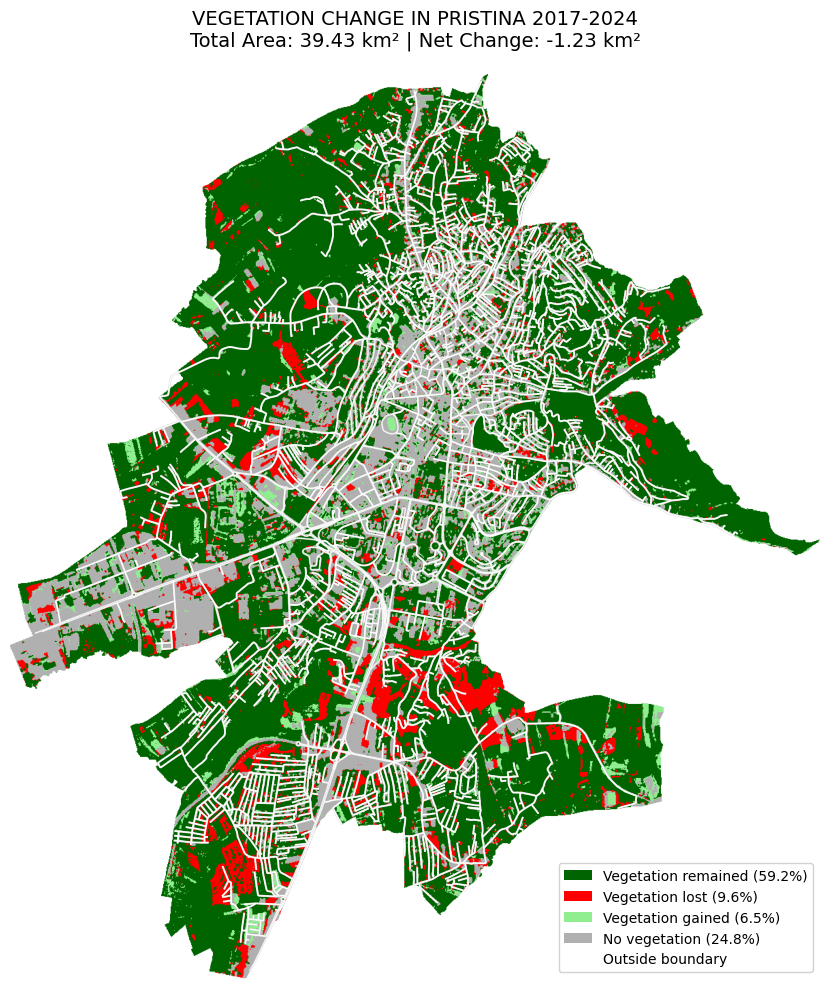

✅ Saved CSV: /content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Final/Vegetation_Comparison/vc_023.csv


In [ ]:
# @title Vegetation Change Analysis Threshold 0.23 (2017 vs 2024) + Roads + CSV
threshold_label = "0.23"

raster_2017_path = '/content/drive/MyDrive/NDVI/NDVI_Python/2017_NDVI_Urban_Zone_Pristina/2017_Threshold_0.23/17_phenology_classification_023_threshold.tif'
raster_2024_path = '/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.23/phenology_classification_023_threshold.tif'
aoi_path = '/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Border/Border_Urban_Pristina.geojson'

out_png = os.path.join(out_dir, "vc_023.png")
out_csv = os.path.join(out_dir, "vc_023.csv")

print("=== DATA VERIFICATION ===")
with rasterio.open(raster_2017_path) as src17:
    print("2017 CRS:", src17.crs)
    print("2017 Unique values:", np.unique(src17.read(1)))
    transform = src17.transform

with rasterio.open(raster_2024_path) as src24:
    print("2024 CRS:", src24.crs)
    print("2024 Unique values:", np.unique(src24.read(1)))

aoi = gpd.read_file(aoi_path)
aoi_utm = aoi.to_crs(epsg=32634)
print("AOI CRS:", aoi_utm.crs)
print("AOI bounds:", aoi_utm.total_bounds)
print("AOI area (calculated):", aoi_utm.geometry.area.sum() / 1e6, "km²")

def mask_raster_properly(raster_path, aoi_geom):
    with rasterio.open(raster_path) as src:
        full_raster = src.read(1)
        transform_local = src.transform

        aoi_mask = rasterio.features.geometry_mask(
            aoi_geom.geometry,
            out_shape=full_raster.shape,
            transform=transform_local,
            invert=True
        )
        masked_raster = full_raster.copy().astype(float)
        masked_raster[~aoi_mask] = np.nan

    return masked_raster, transform_local, aoi_mask

print("\n=== RASTER MASKING ===")
raster_2017_masked, transform, aoi_mask = mask_raster_properly(raster_2017_path, aoi_utm)
raster_2024_masked, _, _ = mask_raster_properly(raster_2024_path, aoi_utm)

print("2017 raster shape:", raster_2017_masked.shape)
print("2024 raster shape:", raster_2024_masked.shape)

pixel_width = transform[0]
pixel_height = -transform[4]
pixel_area_m2 = pixel_width * pixel_height
pixel_area_km2 = pixel_area_m2 / 1e6

total_aoi_pixels = np.sum(~np.isnan(raster_2017_masked))
total_aoi_area_km2 = total_aoi_pixels * pixel_area_km2

print(f"\n=== AREA INFORMATION ===")
print(f"Pixel width: {pixel_width:.2f} m")
print(f"Pixel height: {pixel_height:.2f} m")
print(f"Single pixel area: {pixel_area_m2:.2f} m² ({pixel_area_km2:.6f} km²)")
print(f"Total pixels in AOI: {total_aoi_pixels:,}")
print(f"Total AOI area: {total_aoi_area_km2:.2f} km²")

valid_pixels_2017 = raster_2017_masked[~np.isnan(raster_2017_masked)]
valid_pixels_2024 = raster_2024_masked[~np.isnan(raster_2024_masked)]

veg_2017 = np.sum((valid_pixels_2017 == 1) | (valid_pixels_2017 == 2))
no_veg_2017 = np.sum(valid_pixels_2017 == 0)
deciduous_2017 = np.sum(valid_pixels_2017 == 1)
evergreen_2017 = np.sum(valid_pixels_2017 == 2)

veg_2024 = np.sum((valid_pixels_2024 == 1) | (valid_pixels_2024 == 2))
no_veg_2024 = np.sum(valid_pixels_2024 == 0)
deciduous_2024 = np.sum(valid_pixels_2024 == 1)
evergreen_2024 = np.sum(valid_pixels_2024 == 2)

veg_area_2017_km2 = veg_2017 * pixel_area_km2
veg_area_2024_km2 = veg_2024 * pixel_area_km2

print(f"\n=== YEAR 2017 (Threshold {threshold_label}) ===")
print(f"Total vegetation: {veg_2017:,} px ({veg_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"Vegetation area: {veg_area_2017_km2:.2f} km²")
print(f"  - Deciduous: {deciduous_2017:,} px ({deciduous_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"  - Evergreen: {evergreen_2017:,} px ({evergreen_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"Non-vegetation: {no_veg_2017:,} px ({no_veg_2017/len(valid_pixels_2017)*100:.1f}%)")

print(f"\n=== YEAR 2024 (Threshold {threshold_label}) ===")
print(f"Total vegetation: {veg_2024:,} px ({veg_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"Vegetation area: {veg_area_2024_km2:.2f} km²")
print(f"  - Deciduous: {deciduous_2024:,} px ({deciduous_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"  - Evergreen: {evergreen_2024:,} px ({evergreen_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"Non-vegetation: {no_veg_2024:,} px ({no_veg_2024/len(valid_pixels_2024)*100:.1f}%)")

change_map = np.full(raster_2017_masked.shape, np.nan, dtype=float)

for i in range(raster_2017_masked.shape[0]):
    for j in range(raster_2017_masked.shape[1]):
        if np.isnan(raster_2017_masked[i, j]) or np.isnan(raster_2024_masked[i, j]):
            continue

        val_2017 = raster_2017_masked[i, j]
        val_2024 = raster_2024_masked[i, j]

        if val_2017 in [1, 2] and val_2024 in [1, 2]:
            change_map[i, j] = 1
        elif val_2017 in [1, 2] and val_2024 == 0:
            change_map[i, j] = 2
        elif val_2017 == 0 and val_2024 in [1, 2]:
            change_map[i, j] = 3
        elif val_2017 == 0 and val_2024 == 0:
            change_map[i, j] = 0

change_stats = change_map[~np.isnan(change_map)]
total_change_pixels = len(change_stats)

vegetation_remained = int(np.sum(change_stats == 1))
vegetation_lost = int(np.sum(change_stats == 2))
vegetation_gained = int(np.sum(change_stats == 3))
no_vegetation_both = int(np.sum(change_stats == 0))

area_remained = vegetation_remained * pixel_area_km2
area_lost = vegetation_lost * pixel_area_km2
area_gained = vegetation_gained * pixel_area_km2
net_change_km2 = area_gained - area_lost

print(f"\n=== CHANGE ANALYSIS 2017-2024 ===")
print(f"Total analyzed pixels: {total_change_pixels:,}")
print(f"Vegetation remained: {vegetation_remained:,} px ({vegetation_remained/total_change_pixels*100:.1f}%) - {area_remained:.2f} km²")
print(f"Vegetation lost: {vegetation_lost:,} px ({vegetation_lost/total_change_pixels*100:.1f}%) - {area_lost:.2f} km²")
print(f"Vegetation gained: {vegetation_gained:,} px ({vegetation_gained/total_change_pixels*100:.1f}%) - {area_gained:.2f} km²")
print(f"No vegetation (both years): {no_vegetation_both:,} px ({no_vegetation_both/total_change_pixels*100:.1f}%)")
print(f"NET CHANGE: {net_change_km2:+.2f} km²")

print("\n=== OSM ROADS (overlay) ===")
gdf_roads = gpd.GeoDataFrame(geometry=[], crs="EPSG:32634")

try:
    aoi_ll = aoi_utm.to_crs(epsg=4326)
    poly_ll = aoi_ll.union_all()
    G = ox.graph_from_polygon(poly_ll, network_type="drive", simplify=True)
    gdf_roads = ox.graph_to_gdfs(G, nodes=False, edges=True).to_crs(epsg=32634)
except Exception as e:
    print("⚠️ OSM roads failed:", e)

h, w = change_map.shape
xmin = transform.c
ymax = transform.f
xmax = xmin + w * transform.a
ymin = ymax + h * transform.e  # e is negative
extent = (xmin, xmax, ymin, ymax)

clip_box = box(xmin, ymin, xmax, ymax)
if len(gdf_roads) > 0:
    gdf_roads = gdf_roads[gdf_roads.intersects(clip_box)]
print("Road segments after clip:", len(gdf_roads))

fig, ax = plt.subplots(figsize=(12, 10))

change_colors = ['#B0B0B0', 'darkgreen', 'red', 'lightgreen']
change_cmap = ListedColormap(change_colors)
change_cmap.set_bad('white')

ax.imshow(change_map, cmap=change_cmap, vmin=0, vmax=3, extent=extent, origin='upper', zorder=1)

if len(gdf_roads) > 0:
    gdf_roads.plot(ax=ax, color="#d9d9d9", linewidth=1.4, alpha=0.65, zorder=3)
    gdf_roads.plot(ax=ax, color="white",   linewidth=0.7, alpha=0.90, zorder=4)

legend_elements = [
    Patch(facecolor='darkgreen', label=f'Vegetation remained ({vegetation_remained/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='red', label=f'Vegetation lost ({vegetation_lost/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='lightgreen', label=f'Vegetation gained ({vegetation_gained/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='#B0B0B0', label=f'No vegetation ({no_vegetation_both/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='white', label='Outside boundary')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

ax.set_title(
    f"VEGETATION CHANGE IN PRISTINA 2017-2024\n"
    f"Total Area: {total_aoi_area_km2:.2f} km² | Net Change: {net_change_km2:+.2f} km²",
    fontsize=14, pad=20
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off')

plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"✅ Saved map (300 DPI): {out_png}")
plt.show()

# CSV (short columns)
df = pd.DataFrame([{
    "thr": threshold_label,
    "aoi_km2": total_aoi_area_km2,
    "px_m2": pixel_area_m2,
    "veg17_km2": veg_area_2017_km2,
    "veg24_km2": veg_area_2024_km2,
    "veg17_pct": (veg_2017/len(valid_pixels_2017))*100,
    "veg24_pct": (veg_2024/len(valid_pixels_2024))*100,
    "rem_km2": area_remained,
    "lost_km2": area_lost,
    "gain_km2": area_gained,
    "net_km2": net_change_km2
}])
df.to_csv(out_csv, index=False)
print(f"✅ Saved CSV: {out_csv}")


=== DATA VERIFICATION ===
2017 CRS: EPSG:32634
2017 Unique values: [0 1 2]
2024 CRS: EPSG:32634
2024 Unique values: [0 1 2]
AOI CRS: EPSG:32634
AOI bounds: [ 508740.77891019 4717383.54153357  517510.44657201 4727178.1624051 ]
AOI area (calculated): 39.432845639182986 km²

=== RASTER MASKING ===
2017 raster shape: (1334, 1191)
2024 raster shape: (1334, 1191)

=== AREA INFORMATION ===
Pixel width: 7.37 m
Pixel height: 7.35 m
Single pixel area: 54.17 m² (0.000054 km²)
Total pixels in AOI: 727,862
Total AOI area: 39.43 km²

=== YEAR 2017 (Threshold 0.39) ===
Total vegetation: 262,986 px (36.1%)
Vegetation area: 14.25 km²
  - Deciduous: 261,836 px (36.0%)
  - Evergreen: 1,150 px (0.2%)
Non-vegetation: 464,876 px (63.9%)

=== YEAR 2024 (Threshold 0.39) ===
Total vegetation: 248,380 px (34.1%)
Vegetation area: 13.46 km²
  - Deciduous: 237,792 px (32.7%)
  - Evergreen: 10,588 px (1.5%)
Non-vegetation: 479,482 px (65.9%)

=== CHANGE ANALYSIS 2017-2024 ===
Total analyzed pixels: 727,862
Vegetati

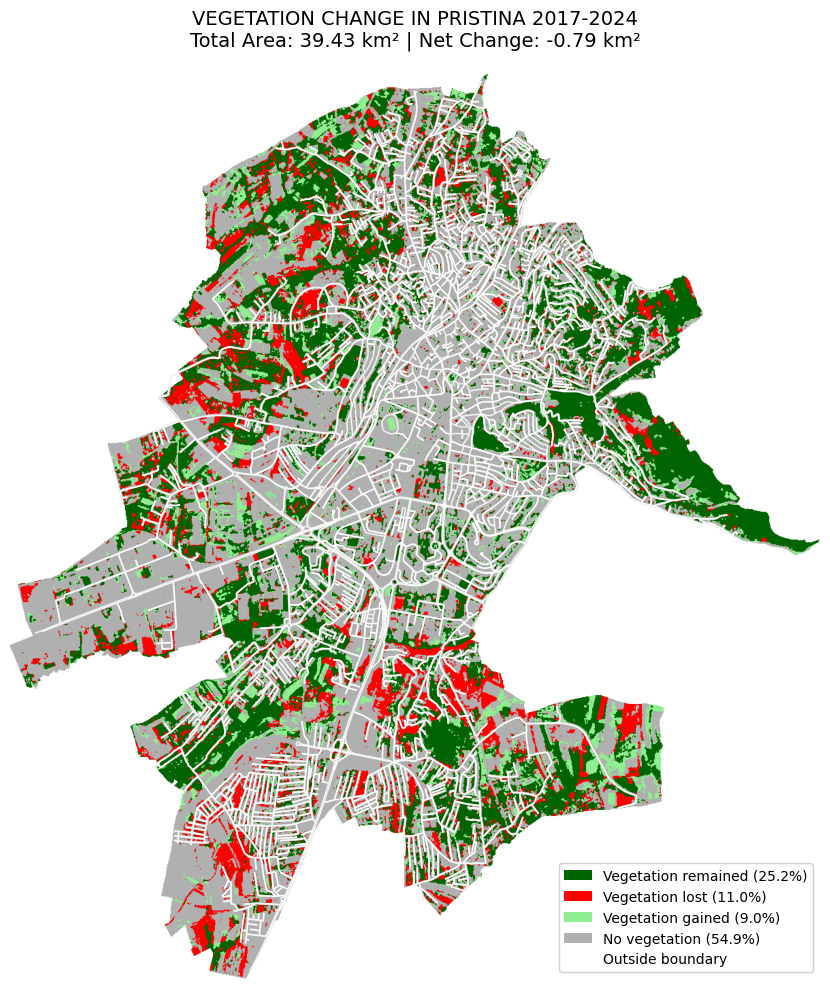

✅ Saved CSV: /content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Final/Vegetation_Comparison/vc_039.csv


In [15]:
# @title Vegetation Change Analysis Threshold 0.39 (2017 vs 2024) + Roads + CSV
threshold_label = "0.39"

raster_2017_path = '/content/drive/MyDrive/NDVI/NDVI_Python/2017_NDVI_Urban_Zone_Pristina/2017_Threshold_0.39/17_phenology_classification_039_threshold.tif'
raster_2024_path = '/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/phenology_classification_039_threshold.tif'
aoi_path = '/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Border/Border_Urban_Pristina.geojson'

out_png = os.path.join(out_dir, "vc_039.png")
out_csv = os.path.join(out_dir, "vc_039.csv")

print("=== DATA VERIFICATION ===")
with rasterio.open(raster_2017_path) as src17:
    print("2017 CRS:", src17.crs)
    print("2017 Unique values:", np.unique(src17.read(1)))
    transform = src17.transform

with rasterio.open(raster_2024_path) as src24:
    print("2024 CRS:", src24.crs)
    print("2024 Unique values:", np.unique(src24.read(1)))

aoi = gpd.read_file(aoi_path)
aoi_utm = aoi.to_crs(epsg=32634)
print("AOI CRS:", aoi_utm.crs)
print("AOI bounds:", aoi_utm.total_bounds)
print("AOI area (calculated):", aoi_utm.geometry.area.sum() / 1e6, "km²")

def mask_raster_properly(raster_path, aoi_geom):
    with rasterio.open(raster_path) as src:
        full_raster = src.read(1)
        transform_local = src.transform

        aoi_mask = rasterio.features.geometry_mask(
            aoi_geom.geometry,
            out_shape=full_raster.shape,
            transform=transform_local,
            invert=True
        )
        masked_raster = full_raster.copy().astype(float)
        masked_raster[~aoi_mask] = np.nan

    return masked_raster, transform_local, aoi_mask

print("\n=== RASTER MASKING ===")
raster_2017_masked, transform, aoi_mask = mask_raster_properly(raster_2017_path, aoi_utm)
raster_2024_masked, _, _ = mask_raster_properly(raster_2024_path, aoi_utm)

print("2017 raster shape:", raster_2017_masked.shape)
print("2024 raster shape:", raster_2024_masked.shape)

pixel_width = transform[0]
pixel_height = -transform[4]
pixel_area_m2 = pixel_width * pixel_height
pixel_area_km2 = pixel_area_m2 / 1e6

total_aoi_pixels = np.sum(~np.isnan(raster_2017_masked))
total_aoi_area_km2 = total_aoi_pixels * pixel_area_km2

print(f"\n=== AREA INFORMATION ===")
print(f"Pixel width: {pixel_width:.2f} m")
print(f"Pixel height: {pixel_height:.2f} m")
print(f"Single pixel area: {pixel_area_m2:.2f} m² ({pixel_area_km2:.6f} km²)")
print(f"Total pixels in AOI: {total_aoi_pixels:,}")
print(f"Total AOI area: {total_aoi_area_km2:.2f} km²")

valid_pixels_2017 = raster_2017_masked[~np.isnan(raster_2017_masked)]
valid_pixels_2024 = raster_2024_masked[~np.isnan(raster_2024_masked)]

veg_2017 = np.sum((valid_pixels_2017 == 1) | (valid_pixels_2017 == 2))
no_veg_2017 = np.sum(valid_pixels_2017 == 0)
deciduous_2017 = np.sum(valid_pixels_2017 == 1)
evergreen_2017 = np.sum(valid_pixels_2017 == 2)

veg_2024 = np.sum((valid_pixels_2024 == 1) | (valid_pixels_2024 == 2))
no_veg_2024 = np.sum(valid_pixels_2024 == 0)
deciduous_2024 = np.sum(valid_pixels_2024 == 1)
evergreen_2024 = np.sum(valid_pixels_2024 == 2)

veg_area_2017_km2 = veg_2017 * pixel_area_km2
veg_area_2024_km2 = veg_2024 * pixel_area_km2

print(f"\n=== YEAR 2017 (Threshold {threshold_label}) ===")
print(f"Total vegetation: {veg_2017:,} px ({veg_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"Vegetation area: {veg_area_2017_km2:.2f} km²")
print(f"  - Deciduous: {deciduous_2017:,} px ({deciduous_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"  - Evergreen: {evergreen_2017:,} px ({evergreen_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"Non-vegetation: {no_veg_2017:,} px ({no_veg_2017/len(valid_pixels_2017)*100:.1f}%)")

print(f"\n=== YEAR 2024 (Threshold {threshold_label}) ===")
print(f"Total vegetation: {veg_2024:,} px ({veg_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"Vegetation area: {veg_area_2024_km2:.2f} km²")
print(f"  - Deciduous: {deciduous_2024:,} px ({deciduous_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"  - Evergreen: {evergreen_2024:,} px ({evergreen_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"Non-vegetation: {no_veg_2024:,} px ({no_veg_2024/len(valid_pixels_2024)*100:.1f}%)")

change_map = np.full(raster_2017_masked.shape, np.nan, dtype=float)

for i in range(raster_2017_masked.shape[0]):
    for j in range(raster_2017_masked.shape[1]):
        if np.isnan(raster_2017_masked[i, j]) or np.isnan(raster_2024_masked[i, j]):
            continue

        val_2017 = raster_2017_masked[i, j]
        val_2024 = raster_2024_masked[i, j]

        if val_2017 in [1, 2] and val_2024 in [1, 2]:
            change_map[i, j] = 1
        elif val_2017 in [1, 2] and val_2024 == 0:
            change_map[i, j] = 2
        elif val_2017 == 0 and val_2024 in [1, 2]:
            change_map[i, j] = 3
        elif val_2017 == 0 and val_2024 == 0:
            change_map[i, j] = 0

change_stats = change_map[~np.isnan(change_map)]
total_change_pixels = len(change_stats)

vegetation_remained = int(np.sum(change_stats == 1))
vegetation_lost = int(np.sum(change_stats == 2))
vegetation_gained = int(np.sum(change_stats == 3))
no_vegetation_both = int(np.sum(change_stats == 0))

area_remained = vegetation_remained * pixel_area_km2
area_lost = vegetation_lost * pixel_area_km2
area_gained = vegetation_gained * pixel_area_km2
net_change_km2 = area_gained - area_lost

print(f"\n=== CHANGE ANALYSIS 2017-2024 ===")
print(f"Total analyzed pixels: {total_change_pixels:,}")
print(f"Vegetation remained: {vegetation_remained:,} px ({vegetation_remained/total_change_pixels*100:.1f}%) - {area_remained:.2f} km²")
print(f"Vegetation lost: {vegetation_lost:,} px ({vegetation_lost/total_change_pixels*100:.1f}%) - {area_lost:.2f} km²")
print(f"Vegetation gained: {vegetation_gained:,} px ({vegetation_gained/total_change_pixels*100:.1f}%) - {area_gained:.2f} km²")
print(f"No vegetation (both years): {no_vegetation_both:,} px ({no_vegetation_both/total_change_pixels*100:.1f}%)")
print(f"NET CHANGE: {net_change_km2:+.2f} km²")

print("\n=== OSM ROADS (overlay) ===")
gdf_roads = gpd.GeoDataFrame(geometry=[], crs="EPSG:32634")

try:
    aoi_ll = aoi_utm.to_crs(epsg=4326)
    poly_ll = aoi_ll.union_all()
    G = ox.graph_from_polygon(poly_ll, network_type="drive", simplify=True)
    gdf_roads = ox.graph_to_gdfs(G, nodes=False, edges=True).to_crs(epsg=32634)
except Exception as e:
    print("⚠️ OSM roads failed:", e)

h, w = change_map.shape
xmin = transform.c
ymax = transform.f
xmax = xmin + w * transform.a
ymin = ymax + h * transform.e  # e is negative
extent = (xmin, xmax, ymin, ymax)

clip_box = box(xmin, ymin, xmax, ymax)
if len(gdf_roads) > 0:
    gdf_roads = gdf_roads[gdf_roads.intersects(clip_box)]
print("Road segments after clip:", len(gdf_roads))

fig, ax = plt.subplots(figsize=(12, 10))

change_colors = ['#B0B0B0', 'darkgreen', 'red', 'lightgreen']
change_cmap = ListedColormap(change_colors)
change_cmap.set_bad('white')

ax.imshow(change_map, cmap=change_cmap, vmin=0, vmax=3, extent=extent, origin='upper', zorder=1)

if len(gdf_roads) > 0:
    gdf_roads.plot(ax=ax, color="#d9d9d9", linewidth=1.4, alpha=0.65, zorder=3)
    gdf_roads.plot(ax=ax, color="white",   linewidth=0.7, alpha=0.90, zorder=4)

legend_elements = [
    Patch(facecolor='darkgreen', label=f'Vegetation remained ({vegetation_remained/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='red', label=f'Vegetation lost ({vegetation_lost/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='lightgreen', label=f'Vegetation gained ({vegetation_gained/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='#B0B0B0', label=f'No vegetation ({no_vegetation_both/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='white', label='Outside boundary')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

ax.set_title(
    f"VEGETATION CHANGE IN PRISTINA 2017-2024\n"
    f"Total Area: {total_aoi_area_km2:.2f} km² | Net Change: {net_change_km2:+.2f} km²",
    fontsize=14, pad=20
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off')

plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"✅ Saved map (300 DPI): {out_png}")
plt.show()

# CSV (short columns)
df = pd.DataFrame([{
    "thr": threshold_label,
    "aoi_km2": total_aoi_area_km2,
    "px_m2": pixel_area_m2,
    "veg17_km2": veg_area_2017_km2,
    "veg24_km2": veg_area_2024_km2,
    "veg17_pct": (veg_2017/len(valid_pixels_2017))*100,
    "veg24_pct": (veg_2024/len(valid_pixels_2024))*100,
    "rem_km2": area_remained,
    "lost_km2": area_lost,
    "gain_km2": area_gained,
    "net_km2": net_change_km2
}])
df.to_csv(out_csv, index=False)
print(f"✅ Saved CSV: {out_csv}")


=== DATA VERIFICATION ===
2017 CRS: EPSG:32634
2017 Unique values: [0 1 2]
2024 CRS: EPSG:32634
2024 Unique values: [0 1 2]
AOI CRS: EPSG:32634
AOI bounds: [ 508740.77891019 4717383.54153357  517510.44657201 4727178.1624051 ]
AOI area (calculated): 39.432845639182986 km²

=== RASTER MASKING ===
2017 raster shape: (1334, 1191)
2024 raster shape: (1334, 1191)

=== AREA INFORMATION ===
Pixel width: 7.37 m
Pixel height: 7.35 m
Single pixel area: 54.17 m² (0.000054 km²)
Total pixels in AOI: 727,862
Total AOI area: 39.43 km²

=== YEAR 2017 (Threshold 0.55) ===
Total vegetation: 42,869 px (5.9%)
Vegetation area: 2.32 km²
  - Deciduous: 42,830 px (5.9%)
  - Evergreen: 39 px (0.0%)
Non-vegetation: 684,993 px (94.1%)

=== YEAR 2024 (Threshold 0.55) ===
Total vegetation: 59,505 px (8.2%)
Vegetation area: 3.22 km²
  - Deciduous: 56,545 px (7.8%)
  - Evergreen: 2,960 px (0.4%)
Non-vegetation: 668,357 px (91.8%)

=== CHANGE ANALYSIS 2017-2024 ===
Total analyzed pixels: 727,862
Vegetation remained: 2

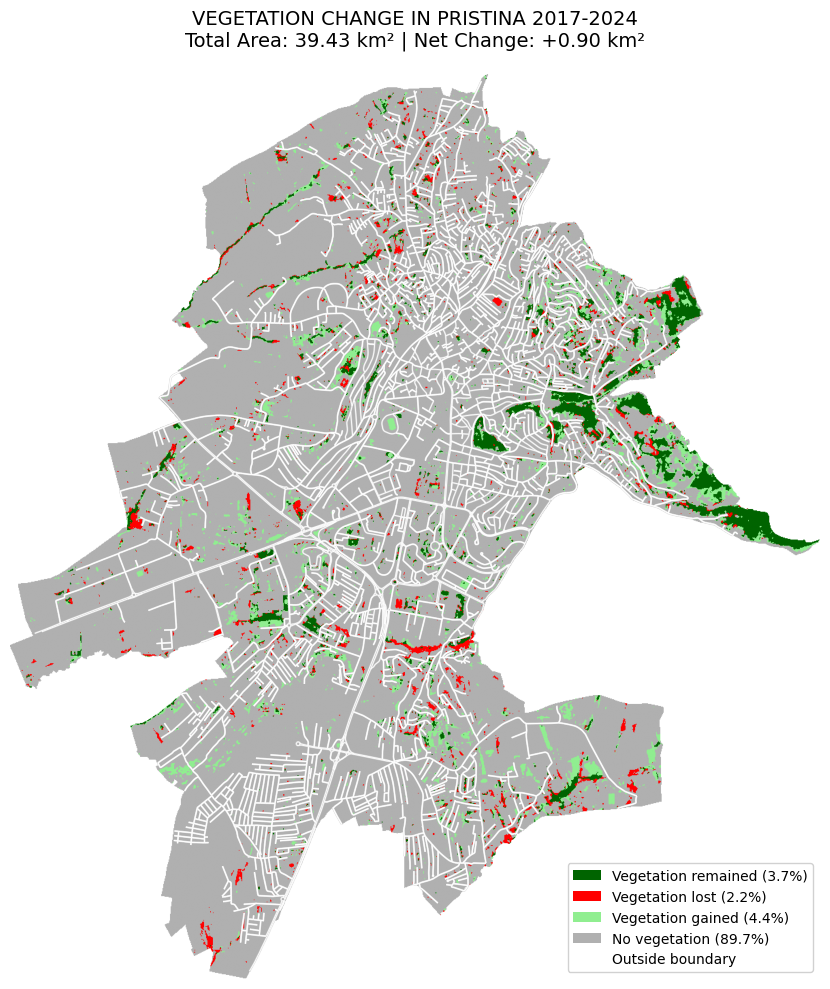

✅ Saved CSV: /content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Final/Vegetation_Comparison/vc_055.csv


In [16]:
# @title Vegetation Change Analysis Threshold 0.55 (2017 vs 2024) + Roads + CSV
threshold_label = "0.55"

raster_2017_path = '/content/drive/MyDrive/NDVI/NDVI_Python/2017_NDVI_Urban_Zone_Pristina/2017_Threshold_0.55/17_phenology_classification_055_threshold.tif'
raster_2024_path = '/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.55/phenology_classification_055_threshold.tif'
aoi_path = '/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Border/Border_Urban_Pristina.geojson'

out_png = os.path.join(out_dir, "vc_055.png")
out_csv = os.path.join(out_dir, "vc_055.csv")

print("=== DATA VERIFICATION ===")
with rasterio.open(raster_2017_path) as src17:
    print("2017 CRS:", src17.crs)
    print("2017 Unique values:", np.unique(src17.read(1)))
    transform = src17.transform

with rasterio.open(raster_2024_path) as src24:
    print("2024 CRS:", src24.crs)
    print("2024 Unique values:", np.unique(src24.read(1)))

aoi = gpd.read_file(aoi_path)
aoi_utm = aoi.to_crs(epsg=32634)
print("AOI CRS:", aoi_utm.crs)
print("AOI bounds:", aoi_utm.total_bounds)
print("AOI area (calculated):", aoi_utm.geometry.area.sum() / 1e6, "km²")

def mask_raster_properly(raster_path, aoi_geom):
    with rasterio.open(raster_path) as src:
        full_raster = src.read(1)
        transform_local = src.transform

        aoi_mask = rasterio.features.geometry_mask(
            aoi_geom.geometry,
            out_shape=full_raster.shape,
            transform=transform_local,
            invert=True
        )
        masked_raster = full_raster.copy().astype(float)
        masked_raster[~aoi_mask] = np.nan

    return masked_raster, transform_local, aoi_mask

print("\n=== RASTER MASKING ===")
raster_2017_masked, transform, aoi_mask = mask_raster_properly(raster_2017_path, aoi_utm)
raster_2024_masked, _, _ = mask_raster_properly(raster_2024_path, aoi_utm)

print("2017 raster shape:", raster_2017_masked.shape)
print("2024 raster shape:", raster_2024_masked.shape)

pixel_width = transform[0]
pixel_height = -transform[4]
pixel_area_m2 = pixel_width * pixel_height
pixel_area_km2 = pixel_area_m2 / 1e6

total_aoi_pixels = np.sum(~np.isnan(raster_2017_masked))
total_aoi_area_km2 = total_aoi_pixels * pixel_area_km2

print(f"\n=== AREA INFORMATION ===")
print(f"Pixel width: {pixel_width:.2f} m")
print(f"Pixel height: {pixel_height:.2f} m")
print(f"Single pixel area: {pixel_area_m2:.2f} m² ({pixel_area_km2:.6f} km²)")
print(f"Total pixels in AOI: {total_aoi_pixels:,}")
print(f"Total AOI area: {total_aoi_area_km2:.2f} km²")

valid_pixels_2017 = raster_2017_masked[~np.isnan(raster_2017_masked)]
valid_pixels_2024 = raster_2024_masked[~np.isnan(raster_2024_masked)]

veg_2017 = np.sum((valid_pixels_2017 == 1) | (valid_pixels_2017 == 2))
no_veg_2017 = np.sum(valid_pixels_2017 == 0)
deciduous_2017 = np.sum(valid_pixels_2017 == 1)
evergreen_2017 = np.sum(valid_pixels_2017 == 2)

veg_2024 = np.sum((valid_pixels_2024 == 1) | (valid_pixels_2024 == 2))
no_veg_2024 = np.sum(valid_pixels_2024 == 0)
deciduous_2024 = np.sum(valid_pixels_2024 == 1)
evergreen_2024 = np.sum(valid_pixels_2024 == 2)

veg_area_2017_km2 = veg_2017 * pixel_area_km2
veg_area_2024_km2 = veg_2024 * pixel_area_km2

print(f"\n=== YEAR 2017 (Threshold {threshold_label}) ===")
print(f"Total vegetation: {veg_2017:,} px ({veg_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"Vegetation area: {veg_area_2017_km2:.2f} km²")
print(f"  - Deciduous: {deciduous_2017:,} px ({deciduous_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"  - Evergreen: {evergreen_2017:,} px ({evergreen_2017/len(valid_pixels_2017)*100:.1f}%)")
print(f"Non-vegetation: {no_veg_2017:,} px ({no_veg_2017/len(valid_pixels_2017)*100:.1f}%)")

print(f"\n=== YEAR 2024 (Threshold {threshold_label}) ===")
print(f"Total vegetation: {veg_2024:,} px ({veg_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"Vegetation area: {veg_area_2024_km2:.2f} km²")
print(f"  - Deciduous: {deciduous_2024:,} px ({deciduous_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"  - Evergreen: {evergreen_2024:,} px ({evergreen_2024/len(valid_pixels_2024)*100:.1f}%)")
print(f"Non-vegetation: {no_veg_2024:,} px ({no_veg_2024/len(valid_pixels_2024)*100:.1f}%)")

change_map = np.full(raster_2017_masked.shape, np.nan, dtype=float)

for i in range(raster_2017_masked.shape[0]):
    for j in range(raster_2017_masked.shape[1]):
        if np.isnan(raster_2017_masked[i, j]) or np.isnan(raster_2024_masked[i, j]):
            continue

        val_2017 = raster_2017_masked[i, j]
        val_2024 = raster_2024_masked[i, j]

        if val_2017 in [1, 2] and val_2024 in [1, 2]:
            change_map[i, j] = 1
        elif val_2017 in [1, 2] and val_2024 == 0:
            change_map[i, j] = 2
        elif val_2017 == 0 and val_2024 in [1, 2]:
            change_map[i, j] = 3
        elif val_2017 == 0 and val_2024 == 0:
            change_map[i, j] = 0

change_stats = change_map[~np.isnan(change_map)]
total_change_pixels = len(change_stats)

vegetation_remained = int(np.sum(change_stats == 1))
vegetation_lost = int(np.sum(change_stats == 2))
vegetation_gained = int(np.sum(change_stats == 3))
no_vegetation_both = int(np.sum(change_stats == 0))

area_remained = vegetation_remained * pixel_area_km2
area_lost = vegetation_lost * pixel_area_km2
area_gained = vegetation_gained * pixel_area_km2
net_change_km2 = area_gained - area_lost

print(f"\n=== CHANGE ANALYSIS 2017-2024 ===")
print(f"Total analyzed pixels: {total_change_pixels:,}")
print(f"Vegetation remained: {vegetation_remained:,} px ({vegetation_remained/total_change_pixels*100:.1f}%) - {area_remained:.2f} km²")
print(f"Vegetation lost: {vegetation_lost:,} px ({vegetation_lost/total_change_pixels*100:.1f}%) - {area_lost:.2f} km²")
print(f"Vegetation gained: {vegetation_gained:,} px ({vegetation_gained/total_change_pixels*100:.1f}%) - {area_gained:.2f} km²")
print(f"No vegetation (both years): {no_vegetation_both:,} px ({no_vegetation_both/total_change_pixels*100:.1f}%)")
print(f"NET CHANGE: {net_change_km2:+.2f} km²")

print("\n=== OSM ROADS (overlay) ===")
gdf_roads = gpd.GeoDataFrame(geometry=[], crs="EPSG:32634")

try:
    aoi_ll = aoi_utm.to_crs(epsg=4326)
    poly_ll = aoi_ll.union_all()
    G = ox.graph_from_polygon(poly_ll, network_type="drive", simplify=True)
    gdf_roads = ox.graph_to_gdfs(G, nodes=False, edges=True).to_crs(epsg=32634)
except Exception as e:
    print("⚠️ OSM roads failed:", e)

h, w = change_map.shape
xmin = transform.c
ymax = transform.f
xmax = xmin + w * transform.a
ymin = ymax + h * transform.e  # e is negative
extent = (xmin, xmax, ymin, ymax)

clip_box = box(xmin, ymin, xmax, ymax)
if len(gdf_roads) > 0:
    gdf_roads = gdf_roads[gdf_roads.intersects(clip_box)]
print("Road segments after clip:", len(gdf_roads))

fig, ax = plt.subplots(figsize=(12, 10))

change_colors = ['#B0B0B0', 'darkgreen', 'red', 'lightgreen']
change_cmap = ListedColormap(change_colors)
change_cmap.set_bad('white')

ax.imshow(change_map, cmap=change_cmap, vmin=0, vmax=3, extent=extent, origin='upper', zorder=1)

if len(gdf_roads) > 0:
    gdf_roads.plot(ax=ax, color="#d9d9d9", linewidth=1.4, alpha=0.65, zorder=3)
    gdf_roads.plot(ax=ax, color="white",   linewidth=0.7, alpha=0.90, zorder=4)

legend_elements = [
    Patch(facecolor='darkgreen', label=f'Vegetation remained ({vegetation_remained/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='red', label=f'Vegetation lost ({vegetation_lost/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='lightgreen', label=f'Vegetation gained ({vegetation_gained/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='#B0B0B0', label=f'No vegetation ({no_vegetation_both/total_change_pixels*100:.1f}%)'),
    Patch(facecolor='white', label='Outside boundary')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

ax.set_title(
    f"VEGETATION CHANGE IN PRISTINA 2017-2024\n"
    f"Total Area: {total_aoi_area_km2:.2f} km² | Net Change: {net_change_km2:+.2f} km²",
    fontsize=14, pad=20
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off')

plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"✅ Saved map (300 DPI): {out_png}")
plt.show()

# CSV (short columns)
df = pd.DataFrame([{
    "thr": threshold_label,
    "aoi_km2": total_aoi_area_km2,
    "px_m2": pixel_area_m2,
    "veg17_km2": veg_area_2017_km2,
    "veg24_km2": veg_area_2024_km2,
    "veg17_pct": (veg_2017/len(valid_pixels_2017))*100,
    "veg24_pct": (veg_2024/len(valid_pixels_2024))*100,
    "rem_km2": area_remained,
    "lost_km2": area_lost,
    "gain_km2": area_gained,
    "net_km2": net_change_km2
}])
df.to_csv(out_csv, index=False)
print(f"✅ Saved CSV: {out_csv}")
